In [1]:
#!pip install matplotlib meshio
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt
from meshGenLib import *

debugMode = False
meshName = 'eqdynaMesh'

ftNamesForGmsh = ['atf1', 'atf2', 'dxs', 'sbt']
ftNames = ['atf', 'dxs', 'sbt']


system = "subei"

# length in meters
dx = 0.5
dxAtBoundary = 20
totalSimuTime = 15
vp = 6000
ext = 10 + totalSimuTime*vp/1e3

tolerance = 1e-6

supPt1 = np.array([-40, -15], dtype=float) 

In [2]:
# generating reference mesh with GMSH without split nodes
gmsh.initialize()
#gmsh.model.geo.setFactory("OpenCASCADE")
gmsh.model.add(meshName)
gmsh.option.setNumber("Geometry.Tolerance", 1e-3)
modelRange={'xmin':0, 
          'xmax':0, 
          'ymin':0, 
          'ymax':0}

ftEndNodeIdDict = {}
ftEndLineIdDict = {}
numOfControlPts = 0
lineCount = 0
surfaceCount = 0
for ftName in ftNamesForGmsh:
    ftFileName = ftName + '.gmt.txt'
    ftLoc = loadFtLoc(ftFileName)
    numOfControlPts, ftEndNodeId, ftRange = createFtPoints(ftLoc, numOfControlPts, dx)
    ftEndNodeIdDict[ftName] = ftEndNodeId
    modelRange = redefineModelRange(modelRange, ftRange)
    lineCount, ftEndLineId = createLinesForFt(ftEndNodeId, lineCount)
    ftEndLineIdDict[ftName] = ftEndLineId
    print(ftLoc)
modelRange = extendModelRange(modelRange, ext)


#print(ftRange)
#print(modelRange)
#print(ftEndNodeIdDict)
#print(ftEndLineIdDict)

numOfControlPts, boundaryNodeIdDict = createBoundaryNodes(numOfControlPts, modelRange, dxAtBoundary)
#print(boundaryNodeIdDict)

# linking faults to model boundary
# this part always needs some customized design
# all lines are defined counterclockwisely.
numOfControlPts+=1
supPt1Id = gmsh.model.geo.addPoint(supPt1[0], supPt1[1], 0, meshSize=dx, tag=numOfControlPts)

atf1Curve = [i+ftEndLineIdDict['atf1'][0] for i in range(ftEndLineIdDict['atf1'][1]-ftEndLineIdDict['atf1'][0]+1)]
atf2Curve = [i+ftEndLineIdDict['atf2'][0] for i in range(ftEndLineIdDict['atf2'][1]-ftEndLineIdDict['atf2'][0]+1)]
dxsCurve = [i+ftEndLineIdDict['dxs'][0] for i in range(ftEndLineIdDict['dxs'][1]-ftEndLineIdDict['dxs'][0]+1)]
sbtCurve = [i+ftEndLineIdDict['sbt'][0] for i in range(ftEndLineIdDict['sbt'][1]-ftEndLineIdDict['sbt'][0]+1)]
#print(atf1Curve, atf2Curve, dxsCurve, sbtCurve)

lineCount += 1
T = gmsh.model.geo.addLine(boundaryNodeIdDict['right_top'], boundaryNodeIdDict['left_top'], tag=lineCount)
lineCount += 1
B = gmsh.model.geo.addLine(boundaryNodeIdDict['right_bottom'], boundaryNodeIdDict['left_bottom'], tag=lineCount)
lineCount += 1
L = gmsh.model.geo.addLine(boundaryNodeIdDict['left_top'], boundaryNodeIdDict['left_bottom'], tag=lineCount)
lineCount += 1
R = gmsh.model.geo.addLine(boundaryNodeIdDict['right_top'], boundaryNodeIdDict['right_bottom'], tag=lineCount)

lineCount += 1
A_LT = gmsh.model.geo.addLine(ftEndNodeIdDict['atf1'][0], boundaryNodeIdDict['left_top'], tag=lineCount) # atf to left top
lineCount += 1
A1_A2 = gmsh.model.geo.addLine(ftEndNodeIdDict['atf1'][1], ftEndNodeIdDict['atf2'][0], tag=lineCount) # atf1 to atf2
lineCount += 1
A_RT = gmsh.model.geo.addLine(ftEndNodeIdDict['atf2'][1], boundaryNodeIdDict['right_top'], tag=lineCount)
lineCount += 1
A_RD = gmsh.model.geo.addLine(ftEndNodeIdDict['atf2'][1], ftEndNodeIdDict['dxs'][1], tag=lineCount)
lineCount += 1
D_RB = gmsh.model.geo.addLine(ftEndNodeIdDict['dxs'][1], boundaryNodeIdDict['right_bottom'], tag=lineCount)
lineCount += 1
supP1_LD = gmsh.model.geo.addLine(supPt1Id, ftEndNodeIdDict['dxs'][0], tag=lineCount)
lineCount += 1
LD_RS = gmsh.model.geo.addLine(ftEndNodeIdDict['dxs'][0], ftEndNodeIdDict['sbt'][1], tag=lineCount)
lineCount += 1
A_supP1 = gmsh.model.geo.addLine(ftEndNodeIdDict['atf1'][0], supPt1Id, tag=lineCount)
lineCount += 1
A_LS = gmsh.model.geo.addLine(ftEndNodeIdDict['atf1'][1], ftEndNodeIdDict['sbt'][0], tag=lineCount)
lineCount += 1
S_LD = gmsh.model.geo.addLine(ftEndNodeIdDict['sbt'][1], ftEndNodeIdDict['dxs'][0], tag=lineCount)
lineCount += 1
supP1_LB = gmsh.model.geo.addLine(supPt1Id, boundaryNodeIdDict['left_bottom'], tag=lineCount)

# atf-top block
surfaceCount = createSurface(atf1Curve+[A1_A2]+atf2Curve+[A_RT, T, -A_LT], surfaceCount)
# atf1-sbt-dxs-supP1 block
surfaceCount = createSurface(atf1Curve+[A_LS]+sbtCurve+[S_LD, -supP1_LD, -A_supP1], surfaceCount)
# atf2-dxs-sbt block
curveLoop = atf2Curve+[A_RD]+addMinusToList(dxsCurve[::-1])+[-S_LD]+addMinusToList(sbtCurve[::-1])+[-A_LS]+[A1_A2]
surfaceCount = createSurface(curveLoop, surfaceCount)
# dxs-supP1-bottom block
surfaceCount = createSurface(dxsCurve+[D_RB, B, -supP1_LB, supP1_LD], surfaceCount)
# atf-supP1-left block
surfaceCount = createSurface([A_supP1, supP1_LB, -L, -A_LT], surfaceCount)
# atf-dxs-right block
surfaceCount = createSurface([A_RD, D_RB, -R, -A_RT], surfaceCount)

gmsh.model.geo.synchronize()

for iSur in range(surfaceCount):
    surfaceId = iSur+1
    print('recombining surface id ', surfaceId)
    gmsh.model.mesh.setRecombine(2, surfaceId)
    
#gmsh.model.mesh.coherence() not available in python
gmsh.model.mesh.generate(2)
#gmsh.model.mesh.removeUnusedEntities()
gmsh.write(meshName+'.msh')
gmsh.option.setNumber("Mesh.Smoothing", 2)
#gmsh.finalize()

16  nodes have been created so far.
Fault ends node Ids are  [ 1 16]
15  lines have been created so far.
Ft ends line ids are [ 1 15]
[[-39.25165489   5.02509791]
 [-37.18269797   4.84505415]
 [-35.05130791   4.83654405]
 [-32.99387195   4.62484673]
 [-30.9034697    4.50372356]
 [-28.80450898   4.40611459]
 [-26.6637063    4.42346543]
 [-24.52697957   4.42961771]
 [-22.41007      4.38132278]
 [-20.33421662   4.22022691]
 [-18.240235     4.10893799]
 [-16.20402014   3.83893617]
 [-14.09291239   3.77470087]
 [-11.93071866   3.85082315]
 [ -9.92611409   3.49397279]
 [ -7.91482057   3.15550014]]
35  nodes have been created so far.
Fault ends node Ids are  [17 35]
33  lines have been created so far.
Ft ends line ids are [16 33]
[[-5.7423274   3.25991991]
 [-3.54507136  3.43237509]
 [-1.27062415  3.8169113 ]
 [ 1.00882254  4.21518344]
 [ 3.25727845  4.52830911]
 [ 5.43170779  4.63804847]
 [ 7.57762093  4.66944021]
 [ 9.73702333  4.73789337]
 [12.13984605  5.47513837]
 [14.36417934  5.7219876

In [3]:
ftTag = {}
ftTag['atf'] = atf1Curve+[A1_A2]+atf2Curve
ftTag['dxs'] = dxsCurve
ftTag['sbt'] = sbtCurve
if debugMode==True: 
    print(ftTag)

In [4]:
nodeTagsFtDict={}
xCoorDict={}
yCoorDict={}
for key in ftNames:
    nodeTagsFtDict[key], xCoorDict[key], yCoorDict[key] = extractFtNodes(ftTag[key])
    if debugMode==True:
        print(nodeTagsFtDict[key])

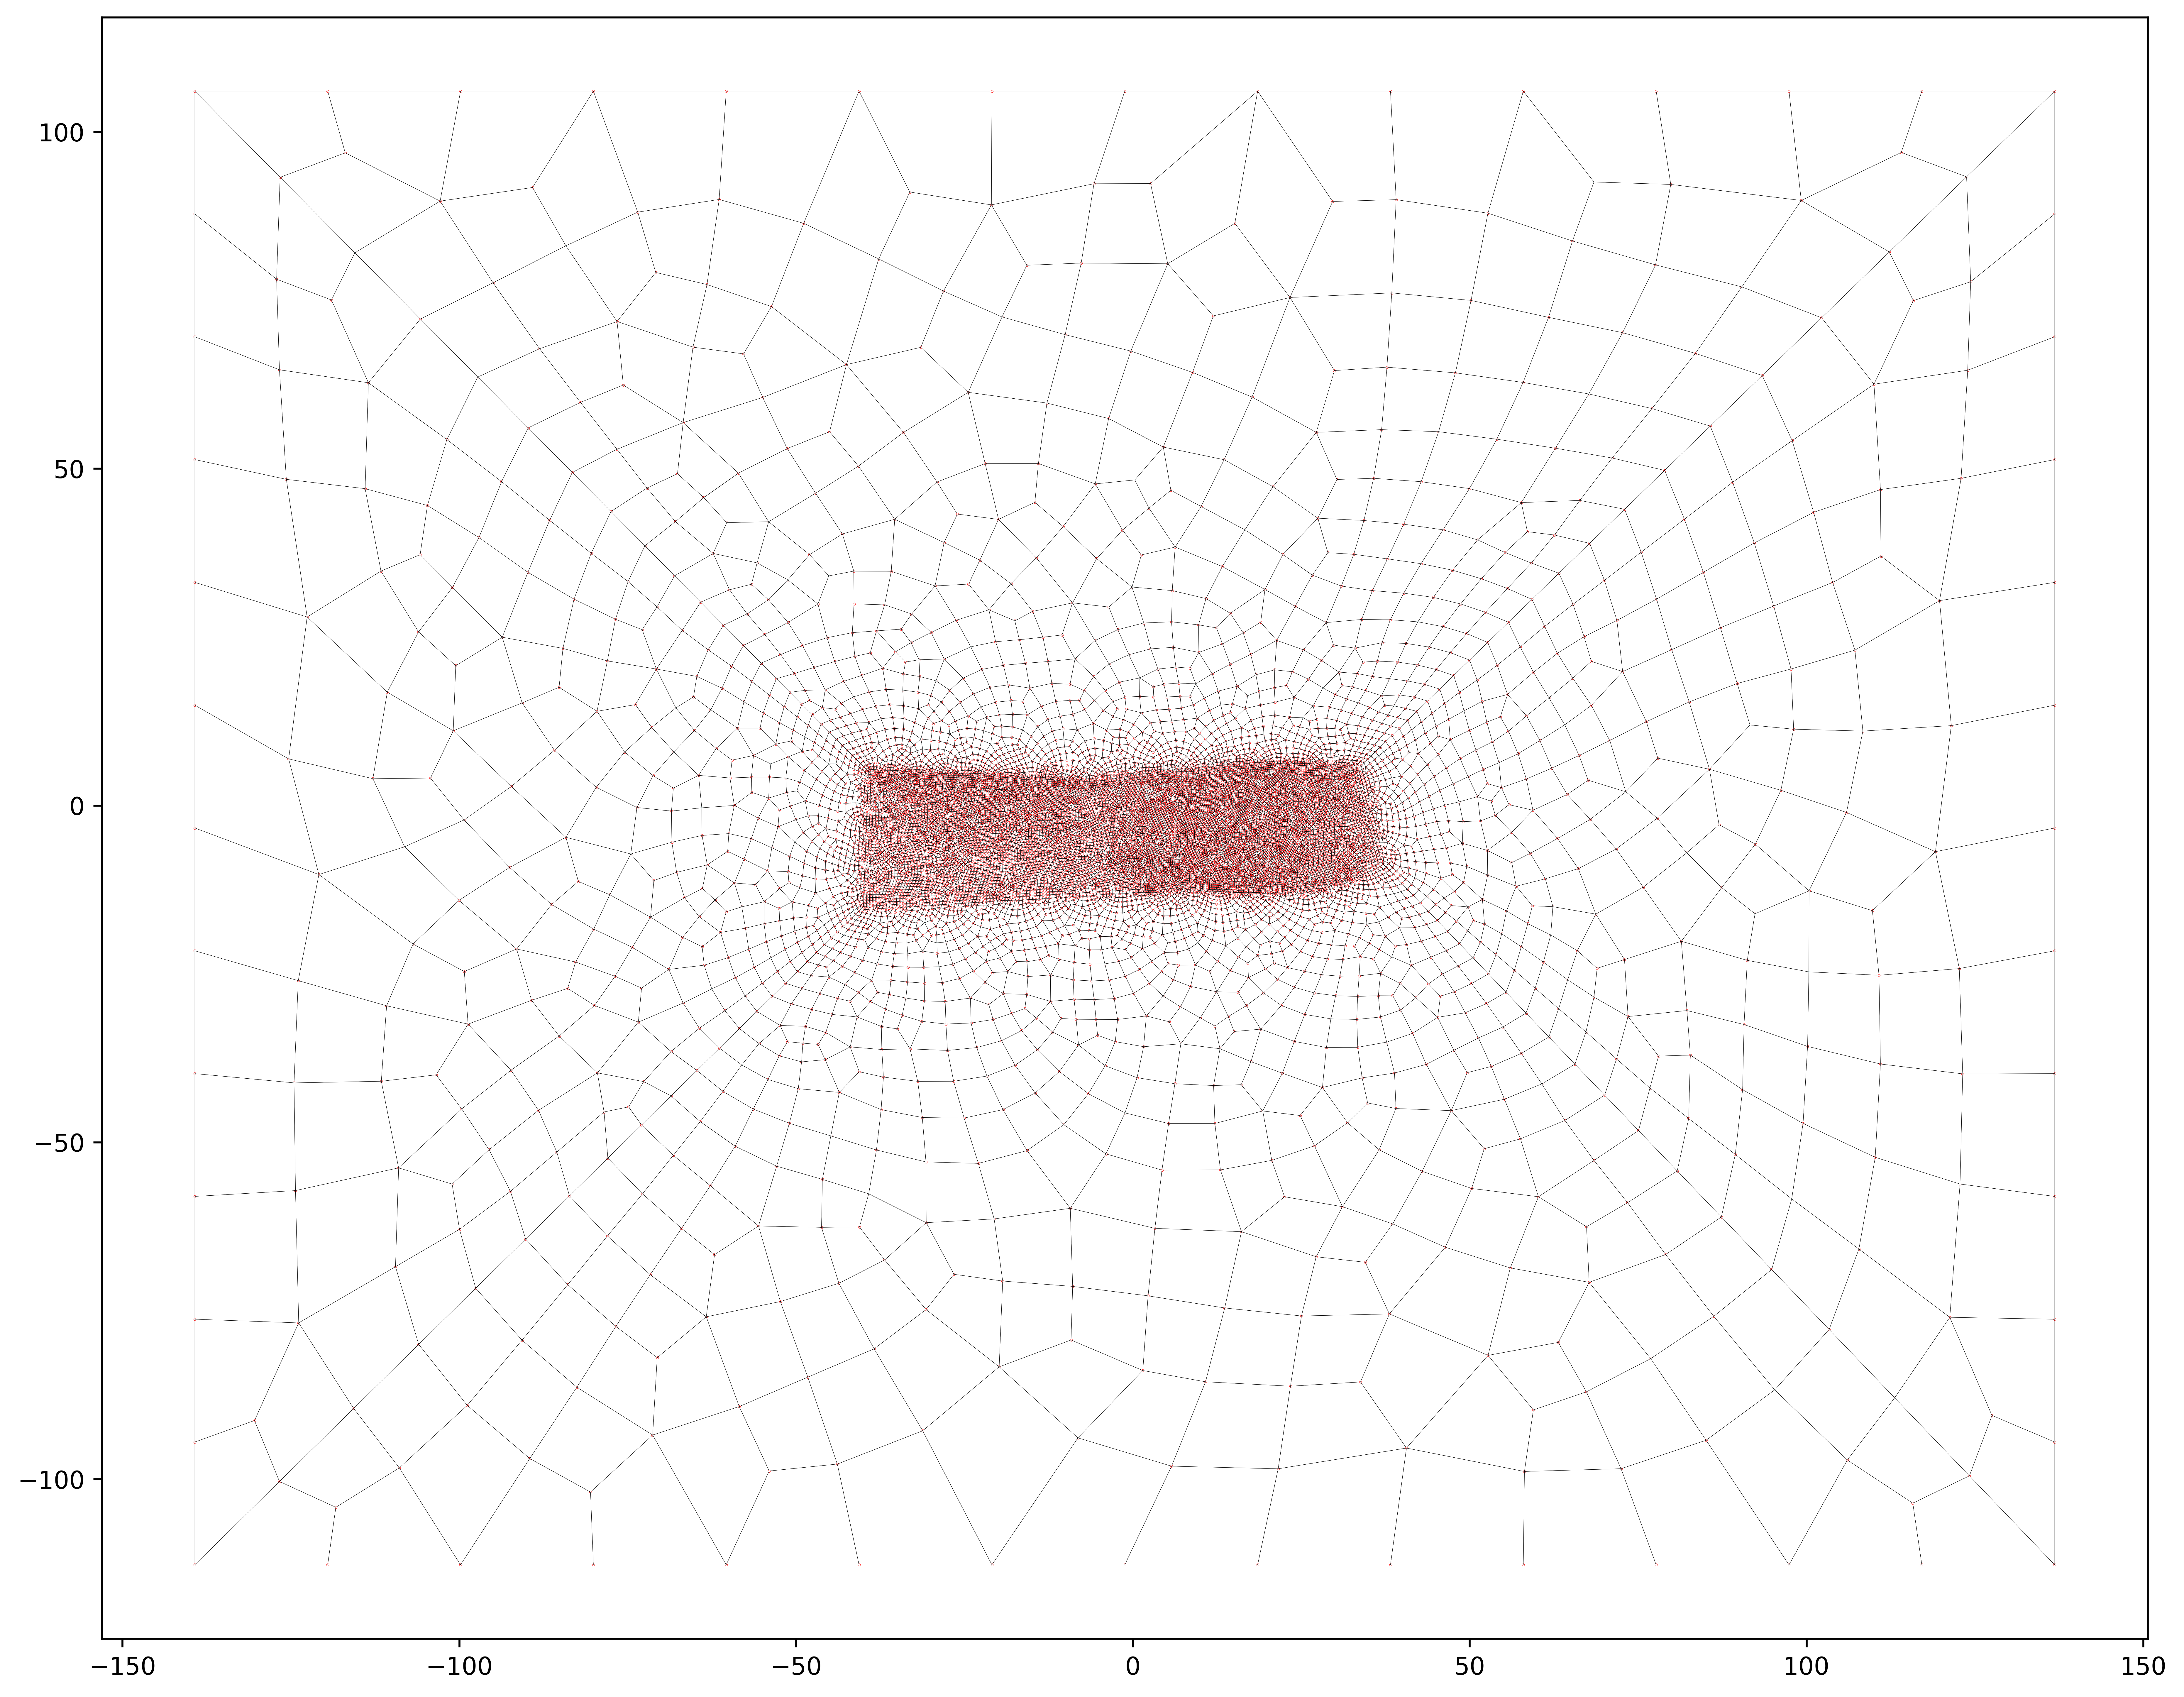

In [5]:
# plotting
mesh = meshio.read(meshName+'.msh')
points = mesh.points[:, :2]  # Get the x, y coordinates
cells = mesh.cells_dict["quad"]  # Assuming quadrilateral elements

fig, ax = plt.subplots(figsize=(15, 20), dpi=600)
ax.scatter(points[:, 0], points[:, 1], s=0.01, color='red', zorder=1)
for cell in cells:
    vertices = points[cell]
    ax.add_patch(plt.Polygon(vertices, edgecolor='black', linewidth=0.1, fill=False))
ax.set_aspect('equal')

plt.savefig('meshWOSplitNode.png', dpi=600)
if debugMode==True:
    plt.show()

In [6]:
ftNodeIdsDict={}
for key in ftNames:
    ftNodeIdsDict[key] = locateFtNodeIds(points, xCoorDict[key], yCoorDict[key], tolerance)
    if debugMode==True:
        print(ftNodeIdsDict[key])

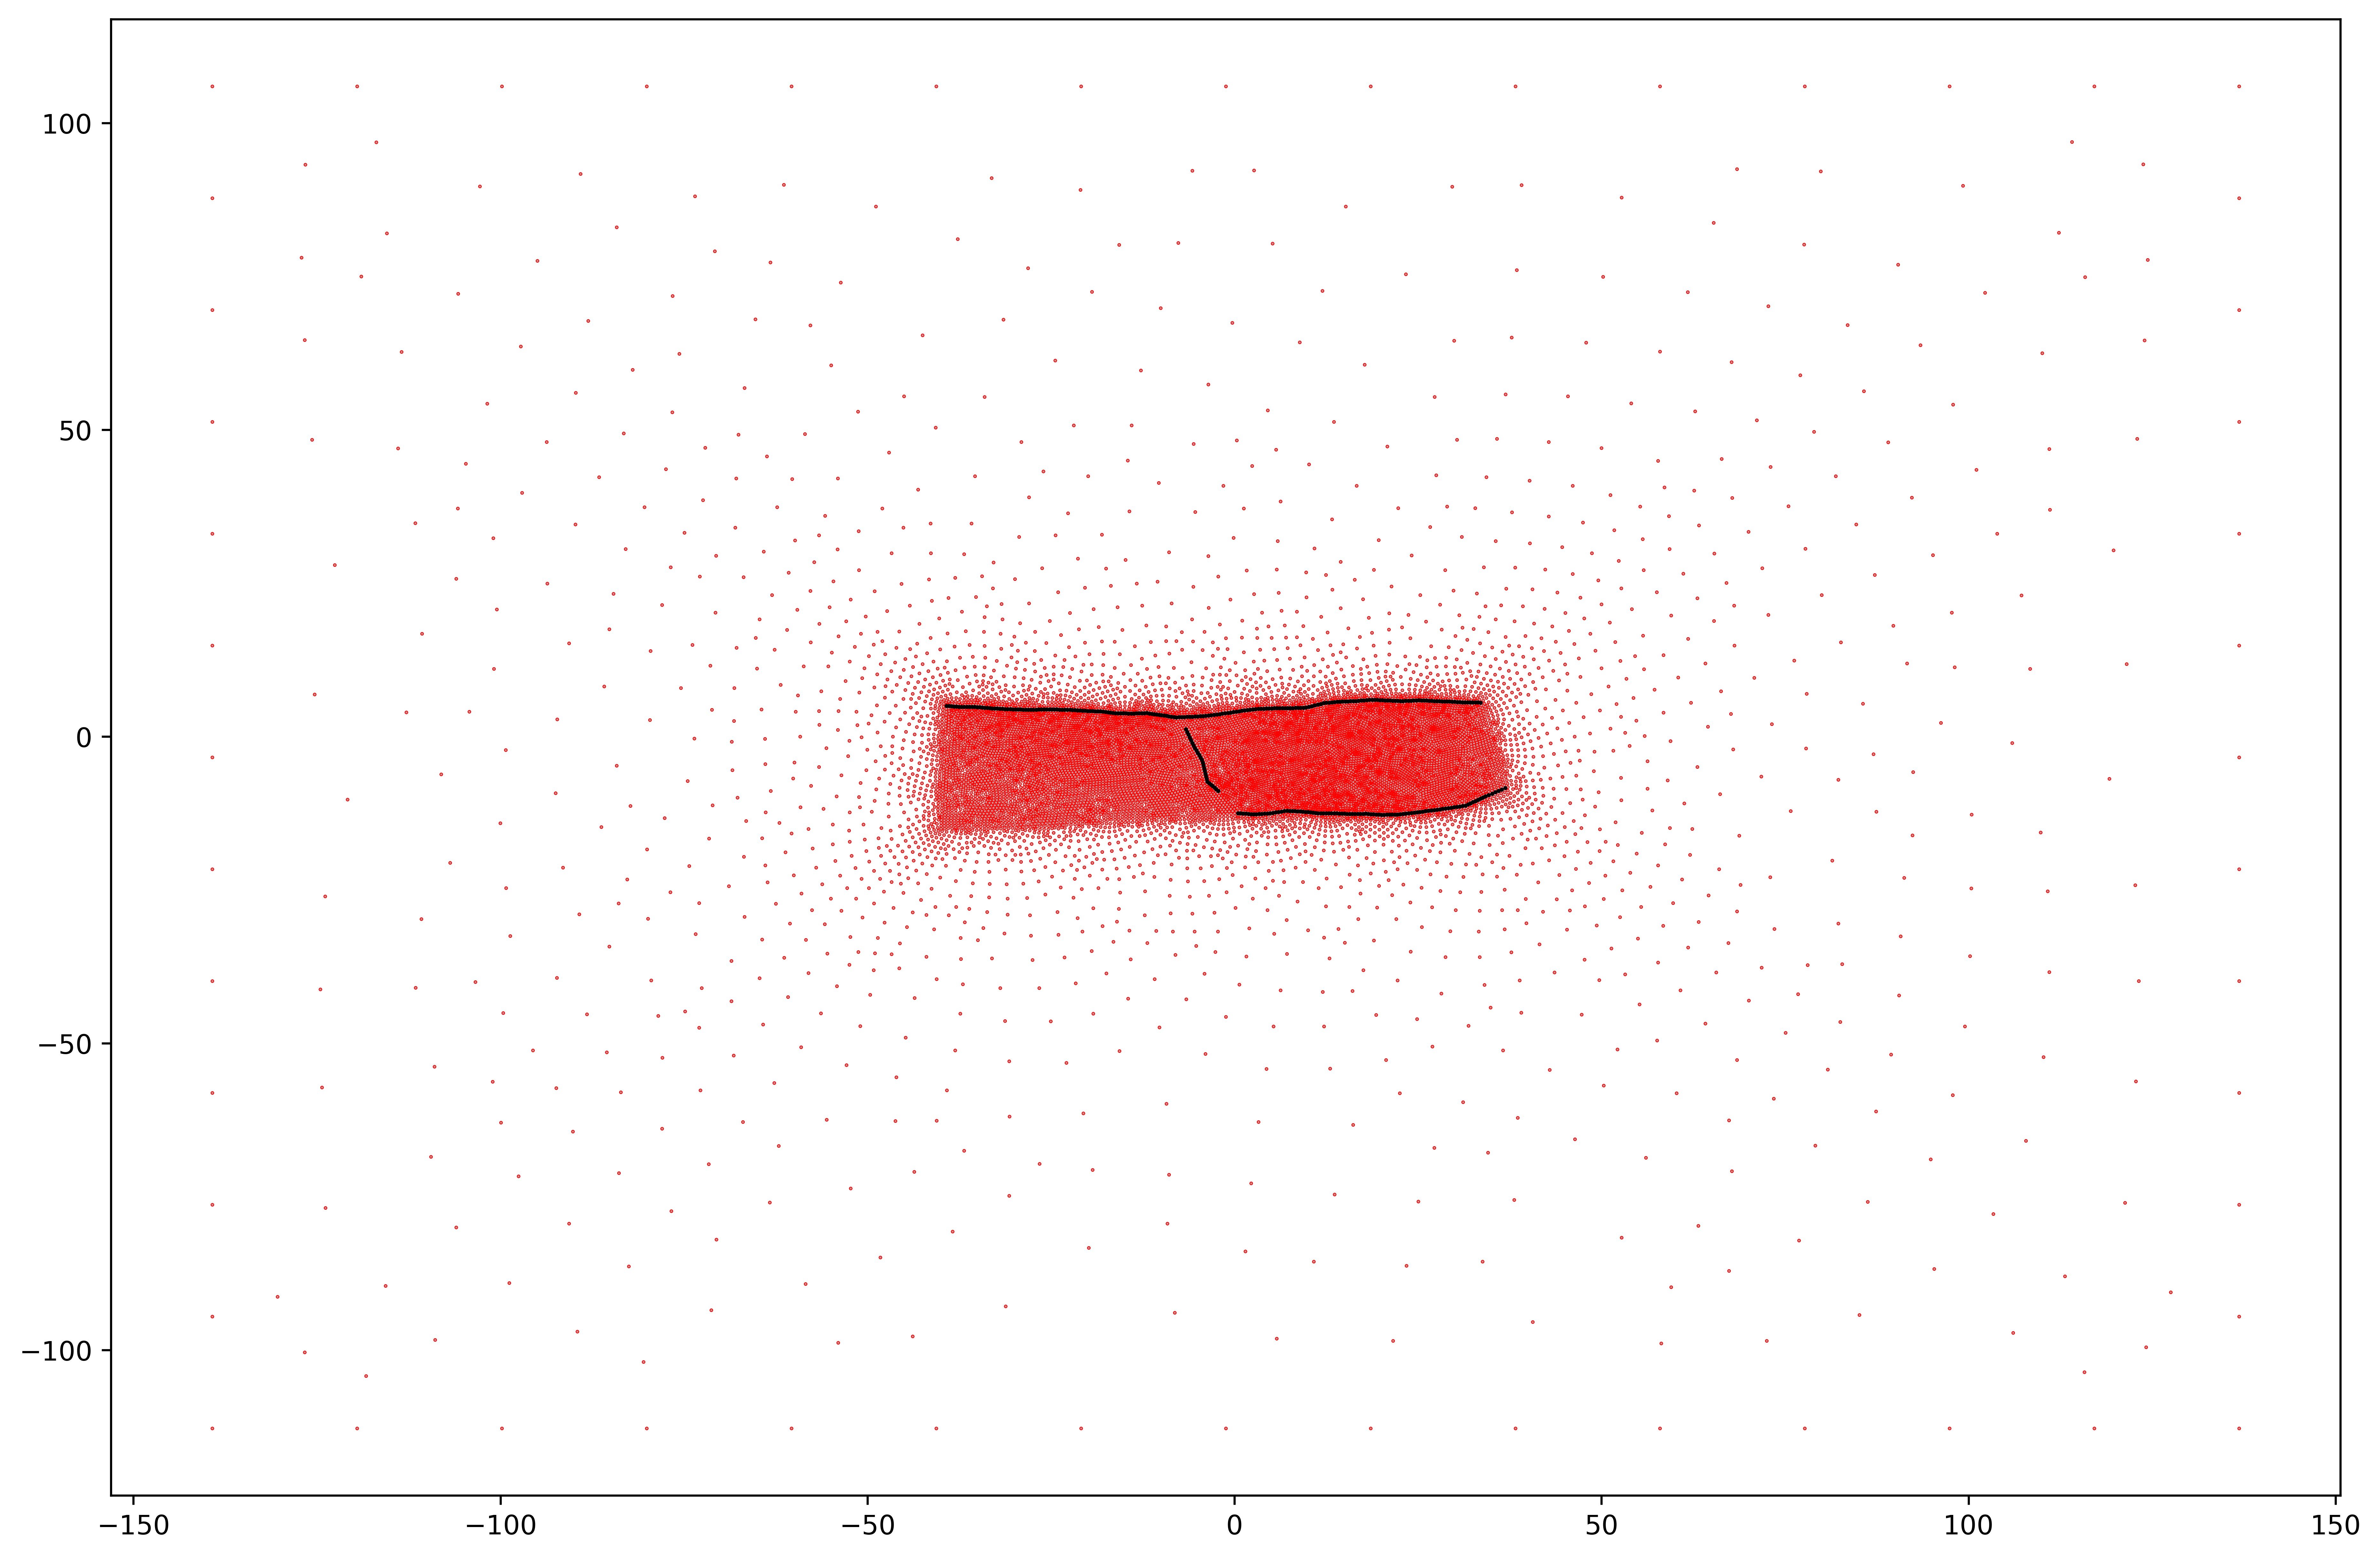

In [7]:
# check and plot ft nodes
fig, ax = plt.subplots(figsize=(15, 10), dpi=600)

ax.scatter(points[:, 0], points[:, 1], s=0.1, color='red', zorder=1)
for ftName in ftNames:
    ax.scatter(points[ftNodeIdsDict[ftName],0], points[ftNodeIdsDict[ftName],1], s=0.3, color='black', zorder=2) 

plt.savefig('meshWithFaultNodes.png', dpi=600)
if debugMode==True:
    plt.show()

In [8]:
elemIdsAboveFtDict = {}
elemIdsBelowFtDict = {}
for key in ftNames:
    elemIdsAboveFtDict[key], elemIdsBelowFtDict[key] = extractIdsforFtElem(ftNodeIdsDict[key], points, cells)

if debugMode==True:
    print(elemIdsAboveFtDict)

In [9]:
slaveNodeIdsDict={}
masterSlaveNodeIdRelation = {}
pointsWithSplitNodes = np.copy(points)
for ftNameKey in ftNames:
    pointsWithSplitNodes, slaveNodeIdsDict[ftNameKey] = createSplitNodes(ftNodeIdsDict[ftNameKey], pointsWithSplitNodes)

    masterSlaveNodeIdRelation[ftNameKey] = [ftNodeIdsDict[ftNameKey], slaveNodeIdsDict[ftNameKey]]

if debugMode==True:
    print(slaveNodeIdsDict)
    print(ftNodeIdsDict)    
    print(' ')
    print(masterSlaveNodeIdRelation)

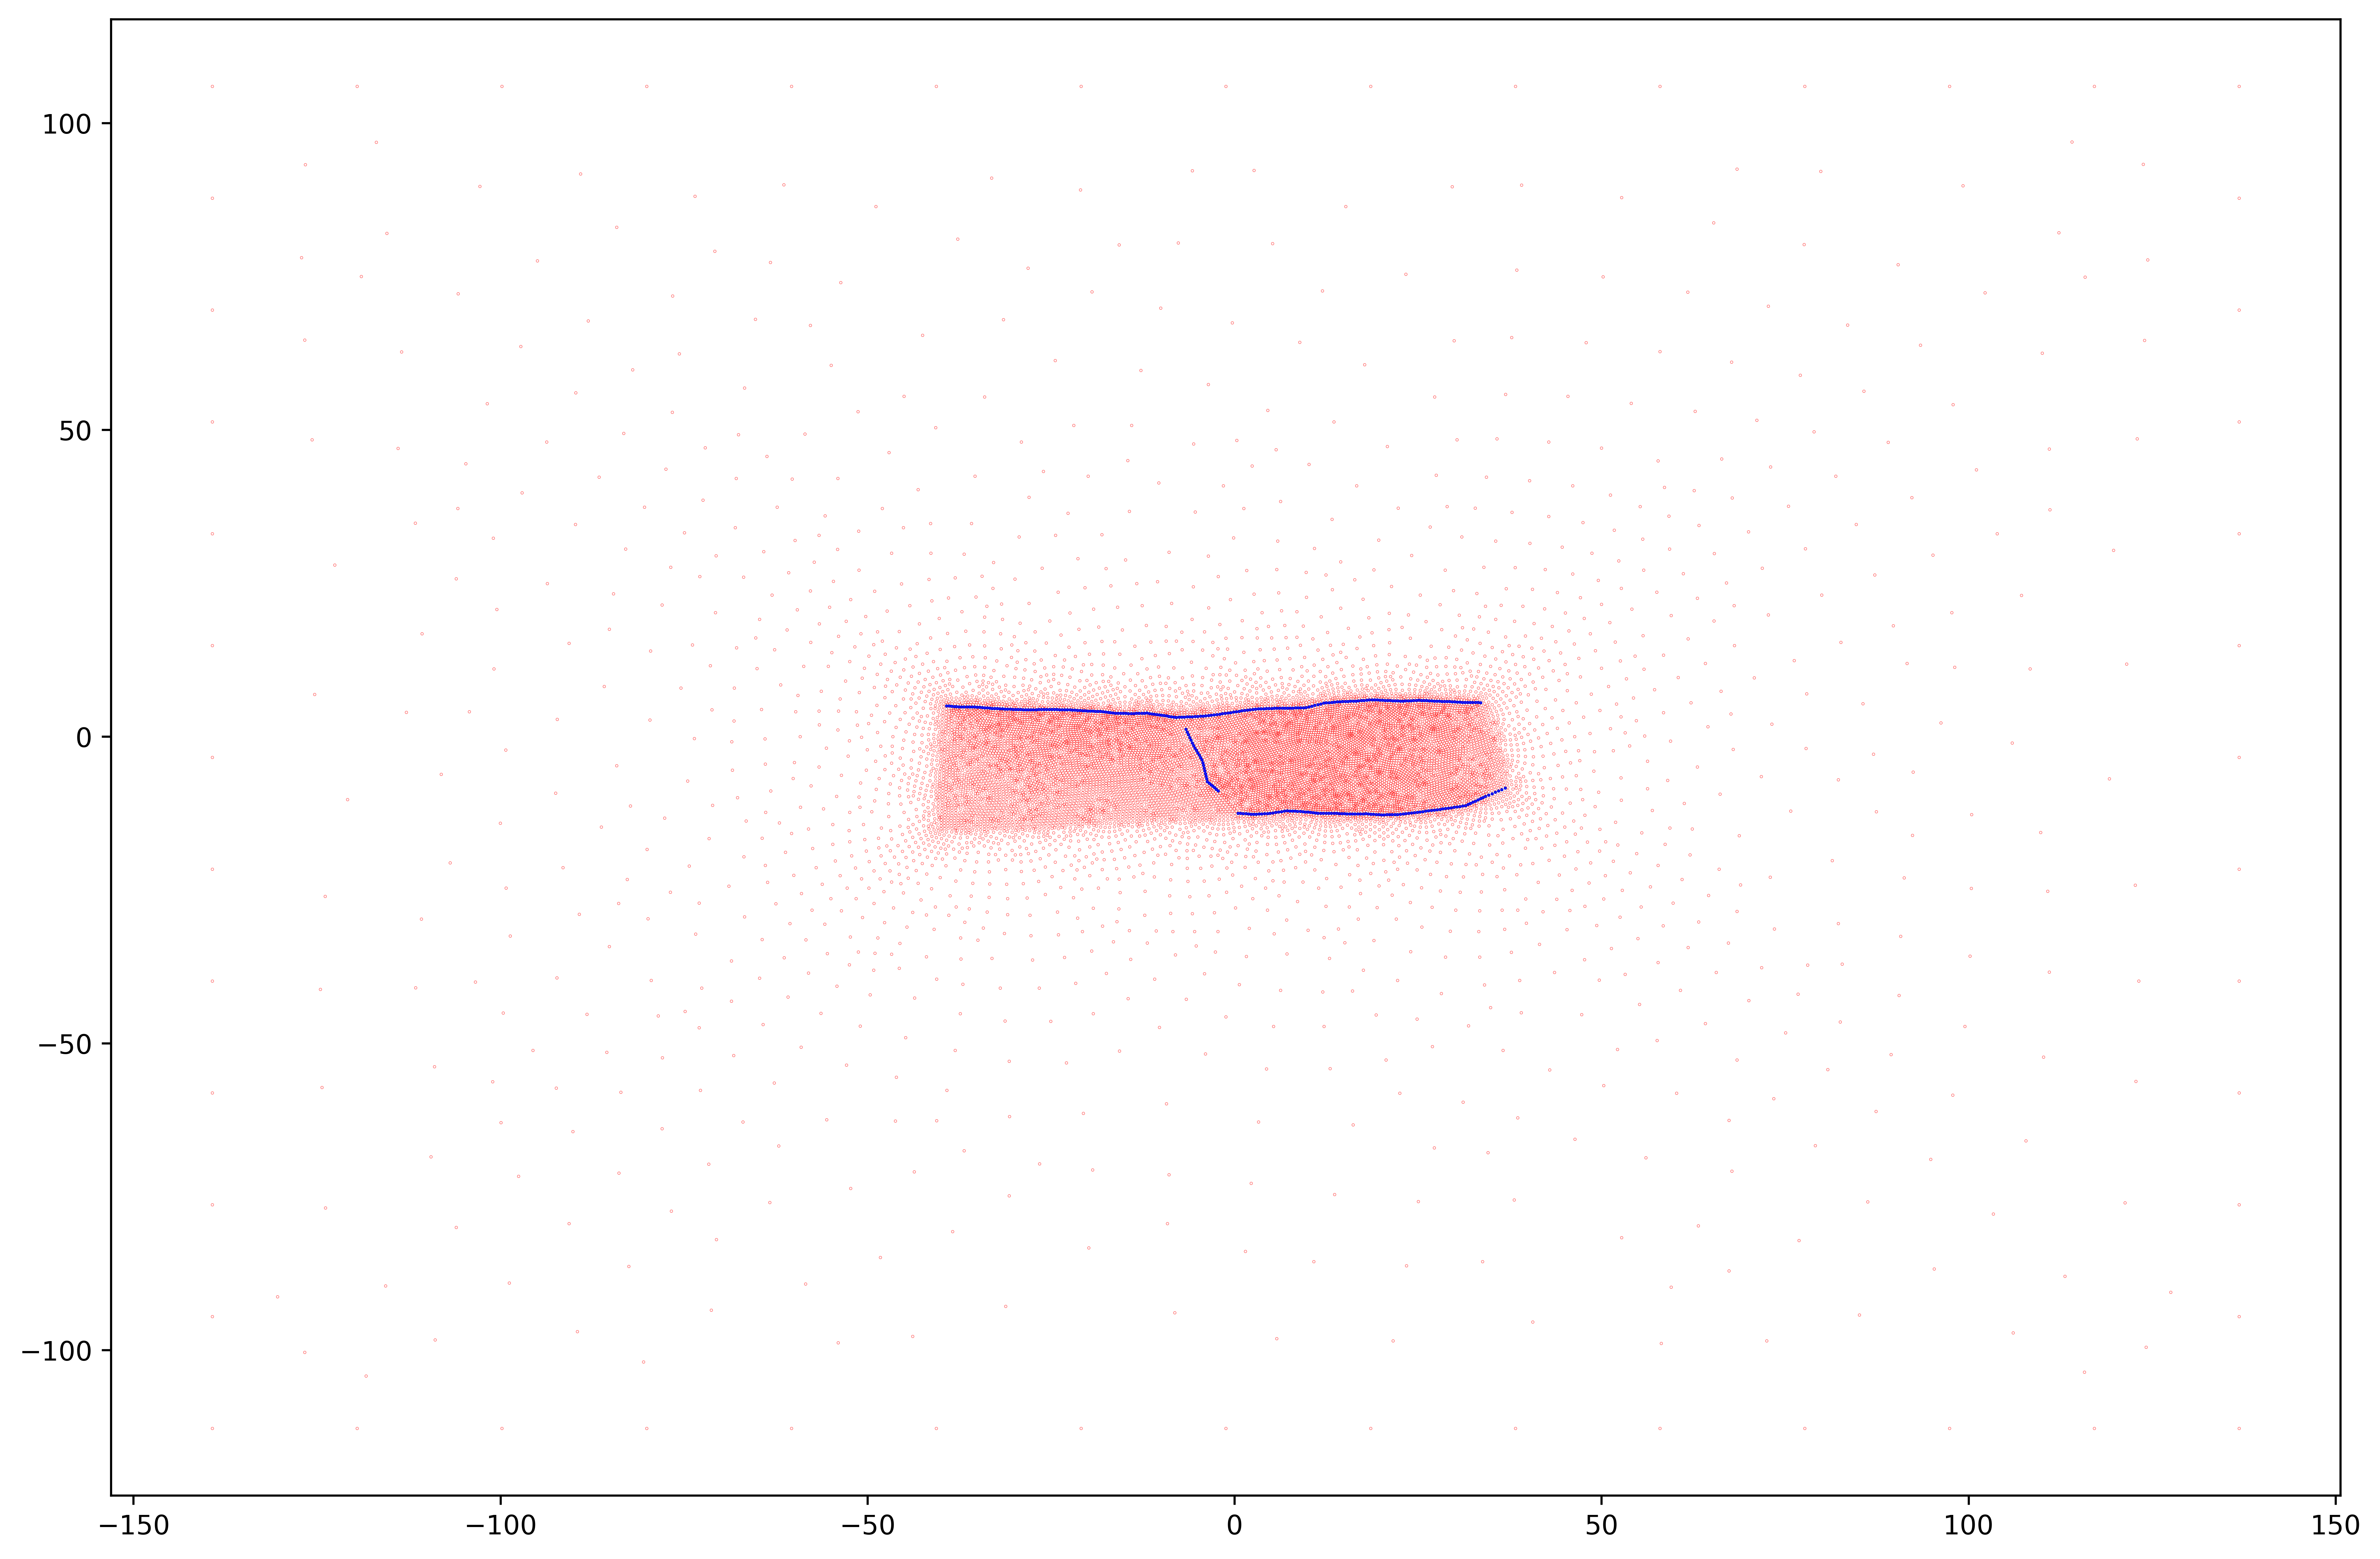

In [10]:
# check and plot ft nodes
fig, ax = plt.subplots(figsize=(15, 10), dpi=600)
plt.scatter(points[:, 0], points[:, 1], s=0.01, color='red', zorder=1)
for key in ftNames:
    plt.scatter(pointsWithSplitNodes[ftNodeIdsDict[key],0], pointsWithSplitNodes[ftNodeIdsDict[key],1], s=0.03, color='black', zorder=2) 
    plt.scatter(pointsWithSplitNodes[slaveNodeIdsDict[key],0], pointsWithSplitNodes[slaveNodeIdsDict[key],1], marker='*', s=0.003, color='blue', zorder=2) 
#plt.savefig('mesh.png', dpi=600)
if debugMode==True:
    plt.show()

In [11]:
for ftNameKey in ftNames:
    #print(masterSlaveNodeIdRelation[ftNameKey][1]) 
    cells = replaceMasterWithSlaveNodes(cells, masterSlaveNodeIdRelation[ftNameKey], elemIdsAboveFtDict[ftNameKey])

In [12]:
if debugMode==True:
    # testing if node orders are counterclockwise for cell id 1
    vertices = getCellNodeCoors(cells[1], pointsWithSplitNodes)
    showCellNodes(vertices)
    isThisQuadCounterclockwise(vertices)

In [13]:
## testing if node orders are counterclockwise for cell id 1728 
#vertices = getCellNodeCoors(cells[1728], pointsWithSplitNodes)
#showCellNodes(vertices)
#isThisQuadCounterclockwise(vertices)

In [14]:
reorderedCells = reorderCellNodesCounterclockwise(cells, pointsWithSplitNodes)

In [15]:
ftNodeTanAndLen = {}
for ftNameKey in ftNames:
    ftNodeTanAndLen[ftNameKey] = calcTanAndLen(xCoorDict[ftNameKey], yCoorDict[ftNameKey])

In [16]:
ftPhys = defineSysPhys(system, ftNames, xCoorDict, yCoorDict)

In [17]:
meshInfo, pointsWithSplitNodes, reorderedCells, nsmp, nsmpGeoPhys = \
    writeFilesForEQdyna(pointsWithSplitNodes, reorderedCells, masterSlaveNodeIdRelation, ftNodeTanAndLen, ftPhys, modelRange, ftNames)

In [18]:
if debugMode==True: 
    plotSystemPhys(ftPhys, ftNames, xCoorDict)